In [23]:
try :
  from google.colab import drive
  from google.colab import files
  drive.mount('/content/drive')
  PATH_GC = '/content/drive/My Drive' 
except Exception:
  print("Vous n'êtes pas sur Google Colab, vous êtes en local, assurez-vous d'avoir ajouter le Path du dossier Colab_sources")
  PATH_GC = ''#Emplacement du dossier /Colab_sources

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [25]:
X_train = pd.read_csv(PATH_GC+'/Challenge/X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(PATH_GC+'/Challenge/Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

In [26]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


# Function

In [11]:
def fitBeta(A):
    X_train_reshape2 = torch.tensor(X_train_reshape.values)
    predictors = torch.mm(X_train_reshape2 , A) # the dataframe of the 10 factors created from A with the (date, stock) in index

    targets = Y_train.T.stack()
    targets = torch.tensor(targets.values)
    targets = targets[:,None]

    beta = torch.linalg.inv(torch.mm(predictors.T, predictors))
    beta = torch.mm(beta, predictors.T)
    beta = torch.mm(beta, targets)
    

    
    return beta

def metric(df_y_true, df_y_pred):
    """ Compute metric. """
    if df_y_pred is None:  # If the y_pred has only zeroes, the metric is set to -1.
        return -1.0
    
    y_true = df_y_true.T
    y_pred = df_y_pred.T
    
    y_true = y_true.div(y_true.pow(2.0).sum(1).pow(0.5), 0)
    y_pred = y_pred.div(y_pred.pow(2.0).sum(1).pow(0.5), 0)

    mean_overlap = (y_true * y_pred).sum(1).mean()

    return mean_overlap   

def metric_train(X, beta): 
    
    X_train_reshape2 = torch.tensor(X_train_reshape.values)
    beta = beta.reshape(10,1)
    Ypred = torch.mm(X_train_reshape2, X)
    Ypred = torch.mm(Ypred, beta)
    Ypred = Ypred.reshape(504,50).T 
    Ytrue = torch.tensor(Y_train.values)
    
    for k in range(504):
        Ytrue[:,k] = Ytrue[:,k].clone()/torch.linalg.norm(Ytrue[:,k].clone())

        Ypred[:,k] = Ypred[:,k].clone()/torch.linalg.norm(Ypred[:,k].clone())

    
    meanOverlap = torch.mean(torch.sum(Ytrue*Ypred,dim =  0))

    return 0.2-meanOverlap





# Function Submission

In [12]:
def transform_submission_to_ypred(df_A,df_beta, x_test, y_test):
    """ Transform submission output (A, beta) into predicted returns S_t."""
    df_A = df_A.to_numpy()
    df_beta = df_beta.to_numpy()
    
    A = df_A.reshape((250, 10))
    beta = df_beta.reshape(10)

    E = pd.DataFrame(A.T @ A - np.eye(10)).abs()  

    # check orthogonality of A
    if any(E.unstack() > 1e-6): 
        return None

    x_test = x_test.T
    y_test = y_test.T

    x_test = x_test[y_test.columns]

    x_test_reshape = pd.concat([x_test.shift(i+1).stack(dropna=False) for i in range(250)], 1).dropna()
    y_pred = (x_test_reshape @ A @ beta).unstack()

    return y_pred.T

def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

def fitBeta_df(A):
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

# Training

In [13]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## First model

In [19]:
class descente():
    def __init__(self):
        super(descente, self).__init__()
        #self.A = torch.tensor(A_QRT, requires_grad = True)
        self.A = torch.rand((250,10), requires_grad = True)

    
    def parameters(self):
      return([self.A])

    def forward(self):
        return torch.linalg.qr(self.A, mode='reduced')[0]

In [20]:
model = descente()

n_epochs = 1000
lr = 0.5

optimizer = torch.optim.Adam(model.parameters(), lr)


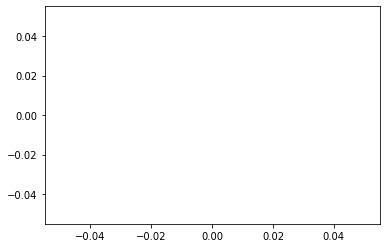

At epochs 1 : 0.06430070326557846
min_loss : 0.06430070326557846


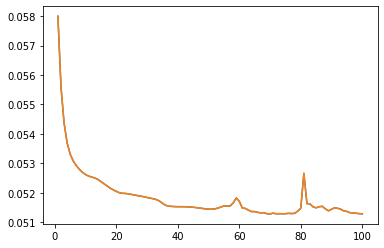

At epochs 101 : 0.05197899079781942
min_loss : 0.05128235114193183


KeyboardInterrupt: ignored

In [27]:
total_loss = 0.0
min_loss = 0.2
Mat_fin = torch.rand(250,10)
Loss_mat = []
Loss_test = []
for j in range(n_epochs):
  
  Mat = model.forward().double()
  Mat.to(device)

  beta  = Mat.clone().detach()
  beta.to(device)
  beta =  fitBeta(beta)
  

  #loss = metric_train(Mat, beta  )
  loss =  metric_train(Mat, beta)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if loss.item() < min_loss:
    min_loss = loss.item()
    Mat_fin = Mat.clone().detach().numpy()


 
  
  total_loss += loss.item()
  if j >0:
    Loss_test.append(metric_train(Mat.detach(), beta))
    Loss_mat.append(loss.item())

  if j%100 ==0:
    abscisse = np.linspace(1,len(Loss_mat), len(Loss_mat))
    plt.plot(abscisse, Loss_mat)
    plt.plot(abscisse, Loss_test)

    plt.show()
    #Loss_mat = []
    print('At epochs '+str(j+1)+' : '+str(total_loss/(j+1)))
    print('min_loss : '+str(min_loss))
    Mat_fin = pd.DataFrame(Mat_fin)
    Mat_fin.to_csv(PATH_GC+'/Challenge/random'+str(j))

# Second model

In [ ]:
class descente():
    def __init__(self):
        super(descente, self).__init__()
        #self.A = torch.tensor(A_QRT, requires_grad = True)
        self.A = torch.rand((250,10), requires_grad = True)
        self.B = torch.rand((10), requires_grad = True)

    def parameters(self):
      return([self.A, self.B])

    def forward(self):
        return torch.linalg.qr(self.A, mode='reduced')[0], self.B

In [ ]:
model = descente()
n_epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)
total_loss = 0.0
min_loss = 0.2
Mat_fin = torch.rand(250,10)
beta_fin = torch.rand(10)
Loss_mat = []
for j in range(n_epochs):
  
  Mat, beta = model.forward()
  Mat.to(device)
  Mat = Mat.double()
  #beta  = Mat.clone().detach()
  beta.to(device)
  beta = beta.double()
  


  loss =  metric_train(Mat, beta)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if loss.item() < min_loss:
    min_loss = loss.item()
    Mat_fin = Mat.clone().detach().numpy()
    beta_fin = beta.clone().detach().numpy()


 
    
  total_loss += loss.item()
  if j >0:

    Loss_mat.append(loss.item())

  if j%50 ==0:
    abscisse = np.linspace(1,len(Loss_mat), len(Loss_mat))
    plt.plot(abscisse, Loss_mat)
    plt.show()
    #Loss_mat = []
    print('At epochs '+str(j+1)+' : '+str(total_loss/(j+1)))
    print('min_loss : '+str(min_loss))
    Mat_fin = pd.DataFrame(Mat_fin)
    Mat_fin.to_csv('./Challenge/A'+str(j))

    beta_fin = pd.DataFrame(beta_fin)
    beta_fin.to_csv('./Challenge/beta'+str(j))
    

# Submission 

In [ ]:
pathA = ''
pathOutput = ''

A = pd.read_csv('./Challenge/'+pathA, index_col=0, sep=',').to_numpy()
#beta = pd.read_csv(PATH_GC+'/Challenge/beta1050', index_col=0, sep=',').to_numpy()

beta = fitBeta_df(A)
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv('./Challenge/'+pathOutput+'.csv')